<a href="https://colab.research.google.com/github/elisecolin/Tutorials_Notebooks/blob/main/S1_burst_ASF_to_numpy_VV_VH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploring Sentinel-1 SLC Bursts with ASF and Python
## Sentinel‑1 **Burst** (ASF) → numpy complex **VV/VH**

This notebook provides a lightweight way to explore Sentinel-1 SLC bursts without downloading the entire SAFE package.
Thanks to the Alaska Satellite Facility (ASF) API, we can directly request and load burst-level data into Python/Colab, and quickly check what phase information brings to the analysis.

**Main objective:**
Have a quick look at what the phase adds in Sentinel-1 SLC burst data — without downloading full products.

**Data Access**
We rely on ASF DAAC burst extraction services.
This allows us to directly obtain GeoTIFFs corresponding to one burst, instead of multi-GB SAFE archives.

This notebook :
1. Configures **Earthdata/ASF** authentication (via a command prompt).
2. Downloads a **Burst** product **from a link** (URL ASF/Vertex/Burst Extractor).
3. Opens complex GeoTIFF files and loads **VV** and **VH** as complex numpy arrays.

⚠️ **Confidentiality**: identifiers are written in the Colab session and do not persist beyond the session.

In [1]:
# @title Dependancy Installation
!pip -q install asf_search rasterio

In [2]:
# @title Authentification Earthdata/ASF
from pathlib import Path
from getpass import getpass

print("Enter your Earthdata ID (used by ASF/Vertex).")
EDL_USER = input("Earthdata username: ")
EDL_PASS = getpass("Earthdata password: ")

netrc_path = Path.home() / '.netrc'
netrc_text = f"""
machine urs.earthdata.nasa.gov
  login {EDL_USER}
  password {EDL_PASS}
machine sentinel1-burst.asf.alaska.edu
  login {EDL_USER}
  password {EDL_PASS}
"""

netrc_path.write_text(netrc_text.strip())
netrc_path.chmod(0o600)
print(f".netrc écrit à {netrc_path}")


Enter your Earthdata ID (used by ASF/Vertex).
Earthdata username: elisekoeniguer
Earthdata password: ··········
.netrc écrit à /root/.netrc


In [3]:
# @title Download settings
import os, re
import asf_search as asf

# Example URL:
# Direct link to Burst Extractor (GeoTIFF) or Data Pool (.zip product)
PRODUCT_URL = "https://sentinel1-burst.asf.alaska.edu/S1C_IW_SLC__1SDV_20250802T233654_20250802T233722_003500_007055_A0B6/IW1/VH/7.tiff"  # @param {type:"string"}
OUT_DIR = "downloads"  # @param {type:"string"}
os.makedirs(OUT_DIR, exist_ok=True)
print("Output Directory:", os.path.abspath(OUT_DIR))
print("Product", PRODUCT_URL)

Output Directory: /content/downloads
Product https://sentinel1-burst.asf.alaska.edu/S1C_IW_SLC__1SDV_20250802T233654_20250802T233722_003500_007055_A0B6/IW1/VH/7.tiff


In [4]:
from urllib.parse import urlparse
import os
import re

def extract_burst_info(url):
    """
    Extract the logical components of an ASF burst URL.
    """
    from urllib.parse import urlparse
    parsed = urlparse(url)
    parts = parsed.path.strip("/").split("/")

    if len(parts) < 4:
        raise ValueError(f"invalid URL : {url}")

    product_id = parts[0]
    subswath = parts[1]
    polarization = parts[2]
    filename = parts[3]

    return {
        "base_url": f"{parsed.scheme}://{parsed.netloc}",
        "product_id": product_id,
        "subswath": subswath,
        "filename": filename,
        "polarizations": ["VV", "VH"],  # can be adapted
    }


In [5]:
def build_burst_urls(info_dict):
    """
    Generates complete URLs for all available polarizations.
    """
    base = info_dict["base_url"]
    urls = {}
    for pol in info_dict["polarizations"]:
        url = f"{base}/{info_dict['product_id']}/{info_dict['subswath']}/{pol}/{info_dict['filename']}"
        urls[pol] = url
    return urls


In [6]:
import requests
from tqdm import tqdm
def download_file(url, out_dir, auth, force_pol=None):
    """
    Télécharge un fichier avec barre de progression.
    Renomme localement avec la polarisation.
    """
    response = requests.get(url, stream=True, auth=auth)
    if response.status_code != 200:
        raise RuntimeError(f"Download failed ({response.status_code}) : {url}")

    filename = os.path.basename(url)
    pol = force_pol if force_pol else filename.split("/")[-2]
    renamed = f"{pol}_{filename}"

    out_path = os.path.join(out_dir, renamed)
    with open(out_path, 'wb') as f, tqdm(
        desc=f"Download {renamed}",
        total=int(response.headers.get('Content-Length', 0)),
        unit='iB',
        unit_scale=True
    ) as bar:
        for chunk in response.iter_content(chunk_size=1024):
            if chunk:
                f.write(chunk)
                bar.update(len(chunk))
    return out_path


In [11]:
os.makedirs(OUT_DIR, exist_ok=True)

# Authentification
session = asf.ASFSession().auth_with_creds(username=EDL_USER, password=EDL_PASS)

# Extraction + construction des URLs
burst_info = extract_burst_info(PRODUCT_URL)
urls = build_burst_urls(burst_info)

downloaded = []

for pol, url in urls.items():
    try:
        out_path = download_file(url, OUT_DIR, auth=(EDL_USER, EDL_PASS), force_pol=pol)
        downloaded.append(out_path)
    except Exception as e:
        print(f"⚠️ Error downloading {pol} : {e}")

print("\nDownloaded files :")
for f in downloaded:
    print(" -", f)


Download VV_7.tiff: 100%|██████████| 140M/140M [00:08<00:00, 17.2MiB/s]
Download VH_7.tiff: 100%|██████████| 140M/140M [00:09<00:00, 14.3MiB/s]


Downloaded files :
 - downloads/VV_7.tiff
 - downloads/VH_7.tiff


In [14]:
channels = {}
for f in downloaded:
    if "VV" in f.upper():
        channels["VV"] = f
    elif "VH" in f.upper():
        channels["VH"] = f
vv_path = channels.get("VV")
vh_path = channels.get("VH")
print(vh_path)


downloads/VH_7.tiff


In [15]:
import rasterio
import numpy as np
def load_tiff_as_array(path):
    with rasterio.open(path) as src:
        array = src.read(1)  # on lit la première bande
    return array


In [16]:
vv_array = load_tiff_as_array(vv_path)
vh_array = load_tiff_as_array(vh_path)

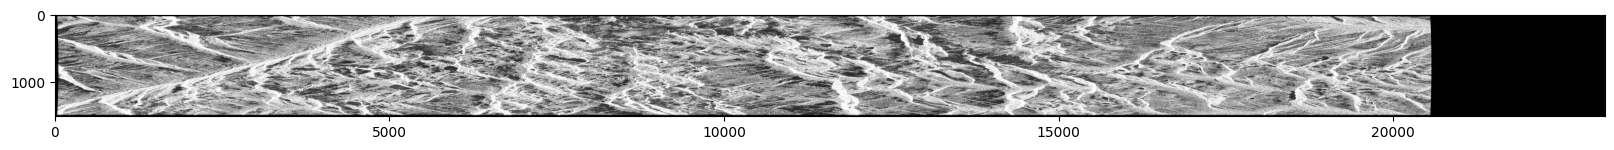

In [17]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,2));
plt.imshow(np.abs(vv_array), cmap='gray',vmin=0,vmax=100)
plt.show()


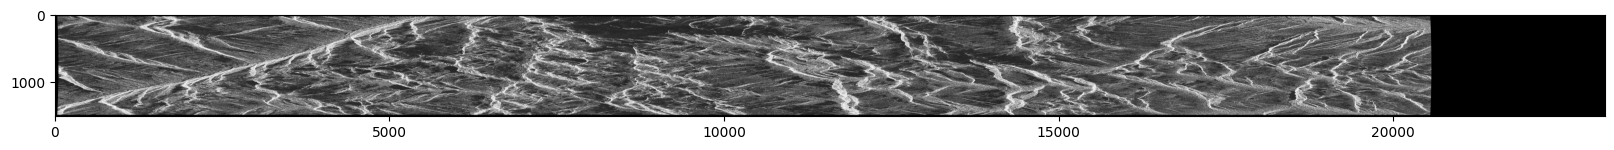

In [18]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,2));
plt.imshow(np.abs(vh_array), cmap='gray',vmin=0,vmax=100)
plt.show()


# Polarimetric Analysis of the Jones Vector

For readers interested in polarimetric interpretation, we recommend Elise Colin’s accessible article:
🔗 [Explore VV, VH or HH, HV SAR time series](https://elisecolin.medium.com/explore-vv-vh-or-hh-hv-sar-time-series-ee9621f29513)

I propose the color composition:
- Saturation → Degree of Polarization
- Hue → Orientation of the polarization ellipse
- Intensity → SPAN (total backscattered power)

This notebook does not perform full polarimetry (Sentinel-1 IW is dual-pol only), but these principles are useful to understand what VV/VH combinations can reveal.

In [19]:
def JonesCoherenceMatrix2DoP(c11, c12, c22):
    """
    Convert coherence matrix elements to Degree of Polarization (DoP).
    Args:
        c11 (numpy.ndarray): Coefficient c11 of the coherence matrix.
        c12 (numpy.ndarray): Coefficient c12 of the coherence matrix.
        c22 (numpy.ndarray): Coefficient c22 of the coherence matrix.
    Returns:
        numpy.ndarray: Degree of Polarization (DoP) computed from the coherence matrix elements.
    """
    num = c11**2 + np.abs(c12)**2 + np.abs(c12)**2 + c22**2
    den = (c11 + c22)**2


    SD = np.divide(2 * num - den, den, out=np.zeros_like(num), where=den != 0)

    return SD

def JonesCoherenceMatrix2Orientation(c11, c12, c22):
    """
    Convert coherence matrix elements to ellipse orientation angle.
    Args:
        c11 (numpy.ndarray): Coefficient c11 of the coherence matrix.
        c12 (numpy.ndarray): Coefficient c12 of the coherence matrix.
        c22 (numpy.ndarray): Coefficient c22 of the coherence matrix.
    Returns:
        OrientationAngle (numpy.ndarray): Orientation angle of the ellipse, normalized between 0 and 1.
        sin2Xhi (numpy.ndarray): Ellipticity of the ellipse, normalized between 0 and 1.
    """
    # Calculate discriminant for eigenvalue calculation
    delta = np.sqrt((c11 - c22)**2 + 4 * np.abs(c12)**2)
    # Calculate the eigenvalue lambda_plus
    lambda_plus = (c11 + c22 + delta) / 2
    # Calculate eigenvector components associated with lambda_plus
    EEx = lambda_plus - c22
    EEy = np.conj(c12)

    # Calculate ellipse orientation angle
    a = np.abs(EEx)**2 - np.abs(EEy)**2
    b = 2 * np.real(EEx * np.conjugate(EEy))
    OrientationAngle = np.arctan2(b,a)
    # Normalize the orientation angle between 0 and 1
    OrientationAngle = (OrientationAngle + np.pi) / (2 * np.pi)

    xhi=np.angle(np.conj(EEy)*EEx)
    sin2Xhi = np.divide(
    2 * np.abs(EEx) * np.abs(EEy) * np.sin(xhi),
    np.abs(EEx)**2 + np.abs(EEy)**2,
    out=np.zeros_like(EEx.real),
    where=(np.abs(EEx)**2 + np.abs(EEy)**2) != 0
    )


    return OrientationAngle,sin2Xhi

In [20]:
from scipy import signal

def ComputeSpatialJonesCoherenceMatrix(Ex, Ey,N=5,M=5):
    """
    Compute the coherence matrix from Spatial Average of electric field components.

    Args:
        Ex (numpy.ndarray): Electric field component in the x-direction (complex).
                           Dimensions: (nx, ny)
        Ey (numpy.ndarray): Electric field component in the y-direction (complex).
                           Dimensions: (nx, ny)
        N,M (int8) : Window size for Estimation: (N x M)

    Returns:
        tuple: A tuple containing three matrices representing the coherence matrix elements:
            - c11 (numpy.ndarray): Coefficient c11 of the coherence matrix. Dimensions: (nx, ny)
            - c12 (numpy.ndarray): Coefficient c12 of the coherence matrix. Dimensions: (nx, ny)
            - c22 (numpy.ndarray): Coefficient c22 of the coherence matrix. Dimensions: (nx, ny)
    """
    win = np.ones((N,M))
    # Calculate covariance matrix elements
    c11 = signal.convolve2d(Ex*np.conj(Ex), win, mode='same')
    c12 = signal.convolve2d(Ex*np.conj(Ey), win, mode='same')
    c22 = signal.convolve2d(Ex*np.conj(Ey), win, mode='same')

    c11=np.abs(c11)
    c22=np.abs(c22)
    return c11, c12, c22

In [21]:
from matplotlib.colors import hsv_to_rgb
def JonesSpatial2rgb(Ex,Ey,N=5,M=5,thresh=None):
    """
    Converts Two images of Jones vectors into two sets of RGB images using polarization parameters.
    for visualizing properties like the orientation angle, degree of polarization (DoP),
    and amplitude of the electric field represented by the Jones vectors.

    Parameters:
    Ex (array_like): An array of complex numbers representing the x-component of the Jones vectors
                     image
    Ey (array_like): An array of complex numbers representing the y-component of the Jones vectors
                     image
    thresh (float, optional): A threshold value used to normalize the amplitude of the polarization
                              ellipse. If not specified, it defaults to the mean plus the standard deviation
                              of the amplitude across all points or times.
    N ( int, optional): the spatial window size to estimate parameters. It defaults to 3.

    Returns:
    tuple: A tuple containing two arrays:
        - rgb1 (array_like): An RGB image derived from converting polarization parameters
                             (orientation angle, square root of DoP, normalized amplitude) to an HSV
                             color space and then converting that to RGB.
        - rgb2 (array_like): An RGB image derived from other polarization parameters
                             (orientation angle, half the sine of twice the ellipticity
                              reduced by one, DoP) to an HSV color space and then to RGB.
    """
    c11, c12, c22=ComputeSpatialJonesCoherenceMatrix(Ex, Ey,N,M)
    OrientationAngle,sin2Xhi=JonesCoherenceMatrix2Orientation(c11, c12, c22)
    SD=JonesCoherenceMatrix2DoP(c11, c12, c22)

    A=np.sqrt(c11+c22)
    # Set threshold to mean plus standard deviation if not specified
    if thresh is None:
        thresh = np.nanmean(A) + np.nanstd(A)
        print('treshold on span amplitude', thresh)
    # Normalize amplitude values between 0 and 1
    A /= thresh
    A = np.clip(A, 0, 1)

    result = np.dstack((OrientationAngle,(SD),A))
    result = np.clip(result, 0, 1)
    rgb1 = hsv_to_rgb(result)

    result = np.dstack((OrientationAngle,(1-sin2Xhi)/2,SD))
    result = np.clip(result, 0, 1)
    rgb2 = hsv_to_rgb(result)

    return rgb1,rgb2

# Visualisation

In [23]:
rgb1,_=JonesSpatial2rgb(vh_array,vv_array,N=2,M=8, thresh=200)

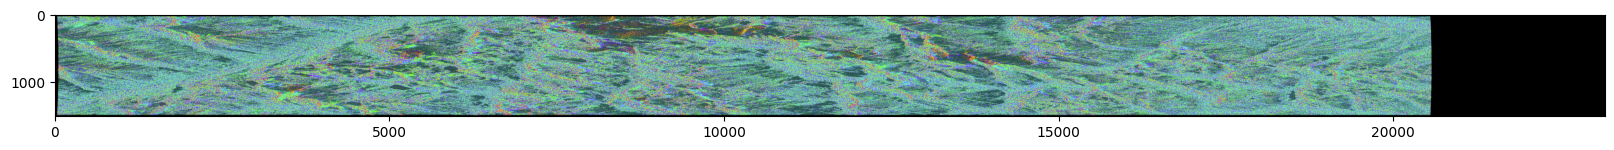

In [24]:
plt.figure(figsize=(20,2))
plt.imshow(rgb1)
plt.show()

In [25]:
import cv2
def shrink_image_x_cv2(rgb, factor):
    """
    Réduit l'image RGB horizontalement (axe X) avec OpenCV.
    """
    H, W, _ = rgb.shape
    new_W = int(W / factor)
    resized = cv2.resize(rgb, (new_W, H), interpolation=cv2.INTER_LINEAR)
    return resized

In [29]:
rgb_shrink=shrink_image_x_cv2(rgb1, 4)


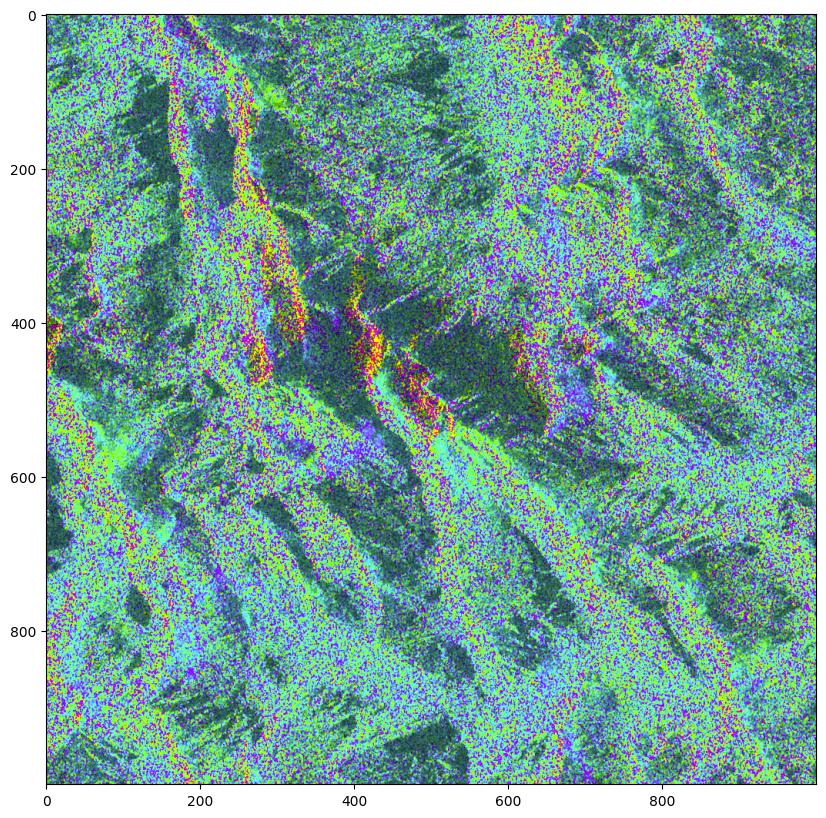

In [31]:
plt.figure(figsize=(10,10))
plt.imshow(rgb_shrink[200:1200,3000:4000,:])
plt.show()